# ASHRAE with fast.ai, Part 2: Training

This kernel leverages the convenient fast.ai API to prepare the dataset for training in just a few lines of code. It then trains a neural network adapted for tabular data.

In order to combine the large size of the ASHRAE dataset and the overhead of fast.ai's objects with the limited memory of Kaggle sessions, this kernel is part of a series which further includes:

- https://www.kaggle.com/michelezoccali/ashrae-with-fast-ai-part-1 (preprocessing)
- https://www.kaggle.com/michelezoccali/ashrae-with-fast-ai-part-3 (inference)

# Imports

In [1]:
import os
import gc
import sys
import psutil

import numpy as np
import pandas as pd
import datetime
import warnings

from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from fastai.tabular.all import *

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

The pre-processed DataFrames can be accessed in the input folder, in the `ashrae-with-fast-ai-part-1` subdirectory.

In [2]:
path = '../input/ashrae-with-fast-ai-part-1/'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-with-fast-ai-part-1/__results__.html
../input/ashrae-with-fast-ai-part-1/preprocessing_no_lag.h5
../input/ashrae-with-fast-ai-part-1/__resultx__.html
../input/ashrae-with-fast-ai-part-1/__notebook__.ipynb
../input/ashrae-with-fast-ai-part-1/__output__.json
../input/ashrae-with-fast-ai-part-1/custom.css


# Load data

Let's load the preprocessed training dataset without lag features.

In [3]:
#%%time
df_train = pd.read_hdf(path + 'preprocessing_no_lag.h5', 'train')
df_train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekday,month,meter_reading
0,105,0,1,0,50623,-1.0,5.0,3.8,0.0,2.4,0.0,0,4,1,3.190624
1,106,0,1,0,5374,-1.0,4.0,3.8,0.0,2.4,0.0,0,4,1,0.318163
2,106,3,1,0,5374,-1.0,4.0,3.8,0.0,2.4,0.0,0,4,1,0.000000
3,107,0,1,0,97532,2005.0,10.0,3.8,0.0,2.4,0.0,0,4,1,5.171529
4,108,0,1,0,81580,1913.0,5.0,3.8,0.0,2.4,0.0,0,4,1,4.524668


In [4]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19869886 entries, 0 to 19869885
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   building_id        uint16 
 1   meter              uint8  
 2   site_id            uint8  
 3   primary_use        uint8  
 4   square_feet        uint32 
 5   year_built         float32
 6   floor_count        float32
 7   air_temperature    float32
 8   cloud_coverage     float32
 9   dew_temperature    float32
 10  precip_depth_1_hr  float32
 11  hour               uint8  
 12  weekday            uint8  
 13  month              uint8  
 14  meter_reading      float32
dtypes: float32(7), uint16(1), uint32(1), uint8(6)
memory usage: 909.6 MB


In [5]:
gc.collect()

40

In [6]:
# use for snapshot of RAM consumption by process
psutil.test()

USER         PID  %MEM     VSZ     RSS  NICE STATUS  START   TIME  CMDLINE
root           1   0.0   11.4M    2.9M        sleep  11:32  00:00  /bin/bash -c 
root           9   0.6  650.9M   99.3M        runni  11:32  00:04  python -c imp
root          24   8.1    9.1G    1.3G        runni  11:32  00:17  /opt/conda/bi


# Modeling

We will be using fast.ai's TabularLearner NN class. One possible way to instantiate such a class is by first defining, among other things:

- Categorical and continuous variables
- A training/validation split
- A set of transforms one wishes to apply to the data
- A TabularPandas object
- A DataLoaders object

Let's do so in order below.

In [7]:
dep_var = 'meter_reading'
cont, cat = cont_cat_split(df_train, max_card=25, dep_var=dep_var)
#cont, cat

In [8]:
df_train[cat].nunique()

meter           4
site_id        16
primary_use    16
hour           24
weekday         7
month          12
dtype: int64

Here we will be doing a simple 11/1 train/validation split for starters. Let us extract the last month of 2016 as validation set.

In [9]:
cond = df_train.month<12
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

df_train = df_train.drop(columns='month') # remove to avoid overfit
cat.remove('month')

Let's tell fast.ai which transforms we wish to apply. Note that here we do not include `FillMissing`, contrary to common practice, as we took care of missing values during preprocessing.

In [10]:
pd.options.mode.chained_assignment = None # to be included alongside reduce_memory=True

procs_nn = [Categorify, Normalize]
df_train = TabularPandas(df_train, procs_nn, cat, cont,
                      splits=splits, y_names=dep_var,
                      inplace=True, reduce_memory=True)

len(df_train.train), len(df_train.valid)

(18143067, 1726819)

TabularPandas instances have a handy method to directly create the `DataLoaders`:

In [11]:
dls = df_train.dataloaders(1024)
gc.collect()

152

Let's establish the range of the target variable, so that we may rescale the outputs of the NN to fill this range by means of a sigmoid activation added as the last layer.

In [12]:
df_train.train.y.min(), df_train.train.y.max()

(0.0, 16.902212)

Instantiate the model and inspect its architecture.

In [13]:
learn = tabular_learner(dls, y_range=(0,17), layers=[500,250], n_out=1, loss_func=F.mse_loss)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(17, 8)
    (2): Embedding(17, 8)
    (3): Embedding(25, 10)
    (4): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=43, out_features=500, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=500, out_features=250, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=250, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=17)
  )
)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0006918309954926372)

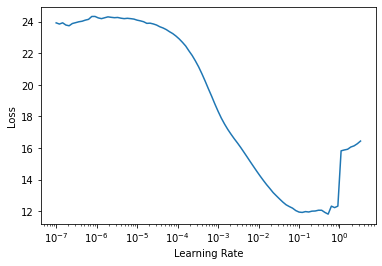

In [14]:
# find appropriate learning rate
learn.lr_find()

Let us now train the model with the 1-cycle policy.

In [15]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,1.338438,1.414644,04:28
1,1.304255,1.299428,04:29
2,1.282917,1.270029,04:27
3,1.249625,1.328734,04:28
4,1.193581,1.269364,04:27
5,1.170001,1.254336,04:24
6,1.121347,1.186581,04:24
7,1.036339,1.149135,04:22
8,0.964187,1.120624,04:23
9,0.929154,1.117309,04:24


Let us check the results of the training by hand.

In [16]:
# this gets predictions on the validation set by default
preds, targs = learn.get_preds()

rmse_valid = np.sqrt(mean_squared_error(to_np(targs.squeeze()), to_np(preds.squeeze())))
rmse_valid

1.0570287

In [17]:
del cond, train_idx, valid_idx, splits
del df_train, dls, preds, targs, rmse_valid
gc.collect()

1203

It seems that the model is performing well on the validation set (as well as LGBM 
in [this kernel](https://www.kaggle.com/michelezoccali/ashrae-energy-prediction-single-lgbm)). Let's save it.

In [18]:
with open('tabular_nn.pickle', mode='wb') as f:
    pickle.dump(learn, f)

That's it. Now we only ought to do inference on the test set. However, trying to create a TabularPandas object for the entire test set in this kernel causes memory peaks which crash the session. Thus, let's continue in:

- https://www.kaggle.com/michelezoccali/ashrae-with-fast-ai-part-3